In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# CLUSTERIZACIÓN 

La idea aquí es separar en **clusters** los datos, explorar las diferencias de variables en cada cluster y luego **entrenar modelos** predictivos en cada cluster, para posteriormente separar en clusters los datos de prueba y aplicarle su correspondiente modelo para realizar las **predicciones**. Con la esperanza de obtener mejores métricas.


In [20]:
cleaned_data= pd.read_csv("Data/train_2.csv")
importances= pd.read_csv('Data/feature_importances.csv')
test= pd.read_csv("Data/test_2.csv")


In [22]:
len(cleaned_data)

1458

### Método del codo.

C:\Users\oscar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\oscar\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\2769136894.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

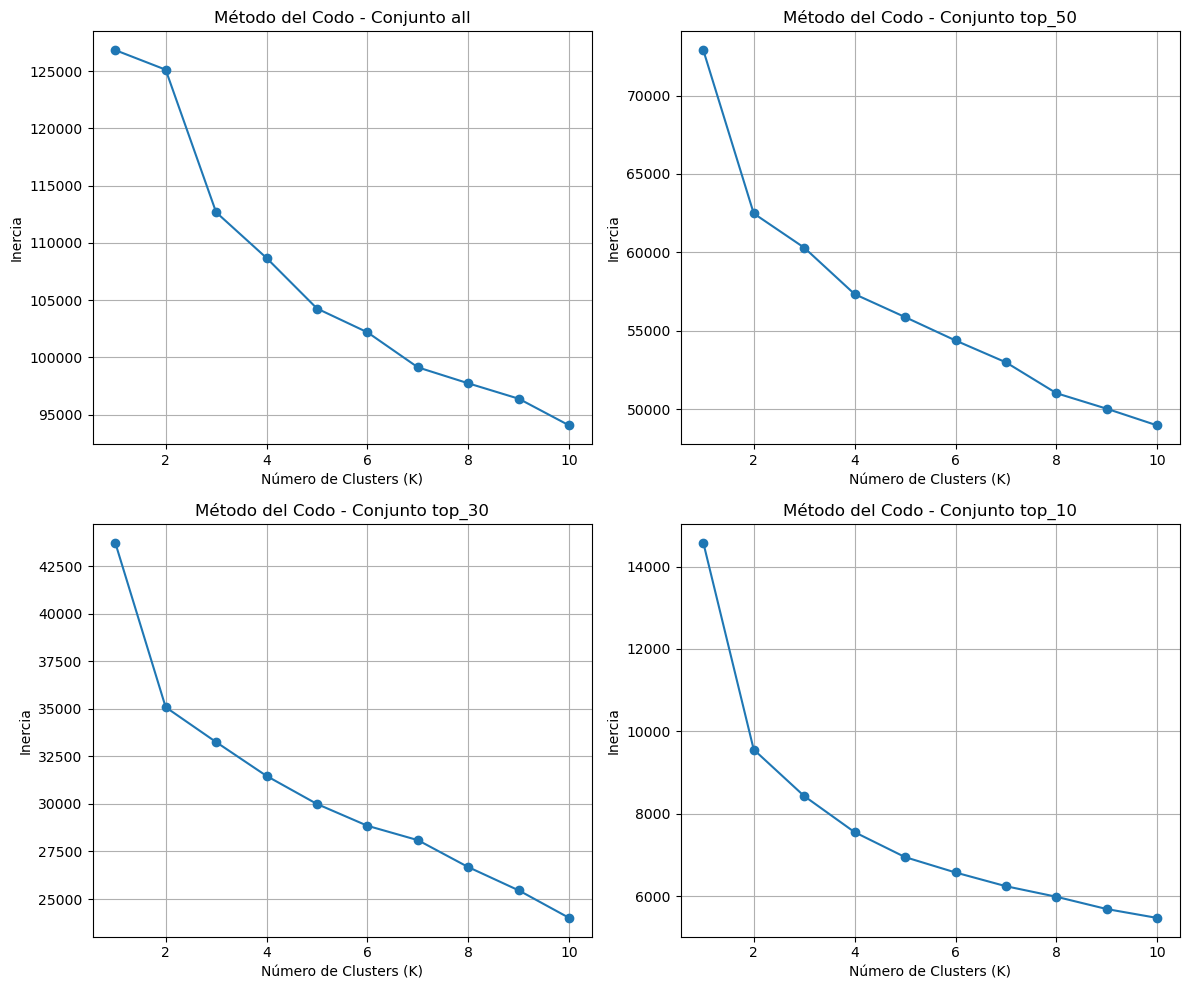

In [4]:
# Crear listas de características para cada tamaño de subconjunto
top_features = {
    'all': cleaned_data.columns.drop('SalePrice').tolist(),
    'top_50': importances['Feature'].head(50).values,
    'top_30': importances['Feature'].head(30).values,
    'top_10': importances['Feature'].head(10).values
}

# DataFrame para almacenar las inercias de cada conjunto y cada K
inertia_df = pd.DataFrame(columns=['Subset', 'K', 'Inertia'])

# Configurar la cuadrícula de gráficos 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Aplanar para un fácil acceso en el bucle

# Iterar sobre cada subconjunto de características
for idx, (label, features) in enumerate(top_features.items()):
    # Seleccionar el subconjunto de características
    X_subset = cleaned_data[features]

    # Normalizar los datos
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(X_subset)

    # Calcular la inercia para diferentes valores de K
    inertia = []
    k_values = range(1, 11)  # Cambia este rango si deseas más o menos valores de K

    for k in k_values:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42)  # Ejecutar KMeans
            kmeans.fit(data_scaled)
            inertia_value = kmeans.inertia_
            inertia.append(inertia_value)

            # Agregar a la tabla
            inertia_df = inertia_df.append({
                'Subset': label,
                'K': k,
                'Inertia': inertia_value
            }, ignore_index=True)

        except Exception as e:
            print(f"Error con k={k} en el conjunto {label}: {e}")
            inertia.append(None)  # Agregar None para mantener la longitud de la lista

    # Graficar el método del codo para este conjunto en el subplot correspondiente
    axes[idx].plot(k_values, inertia, marker='o')
    axes[idx].set_title(f'Método del Codo - Conjunto {label}')
    axes[idx].set_xlabel('Número de Clusters (K)')
    axes[idx].set_ylabel('Inercia')
    axes[idx].grid()

# Ajustar el diseño para evitar solapamientos y mejorar la visualización
plt.tight_layout()
plt.show()

# Guardar la tabla de inercias en un archivo CSV
inertia_df.to_csv('Data/inertia_values.csv', index=False)


Dada la dimensionalidad del modelo, se valora la inercia de cada número de clusters en el conjunto completo de los datos y luego en subconjuntos con **las (50, 30, 10) variables más importantes para el modelo XGBoost**. En todos los casos, el número de **K parece ser 2**, aunque no es una decisión clara.


### Clusterización

C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\3596175831.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset['Cluster'] = kmeans.labels_  # Agregar las etiquetas de clúster
C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\3596175831.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

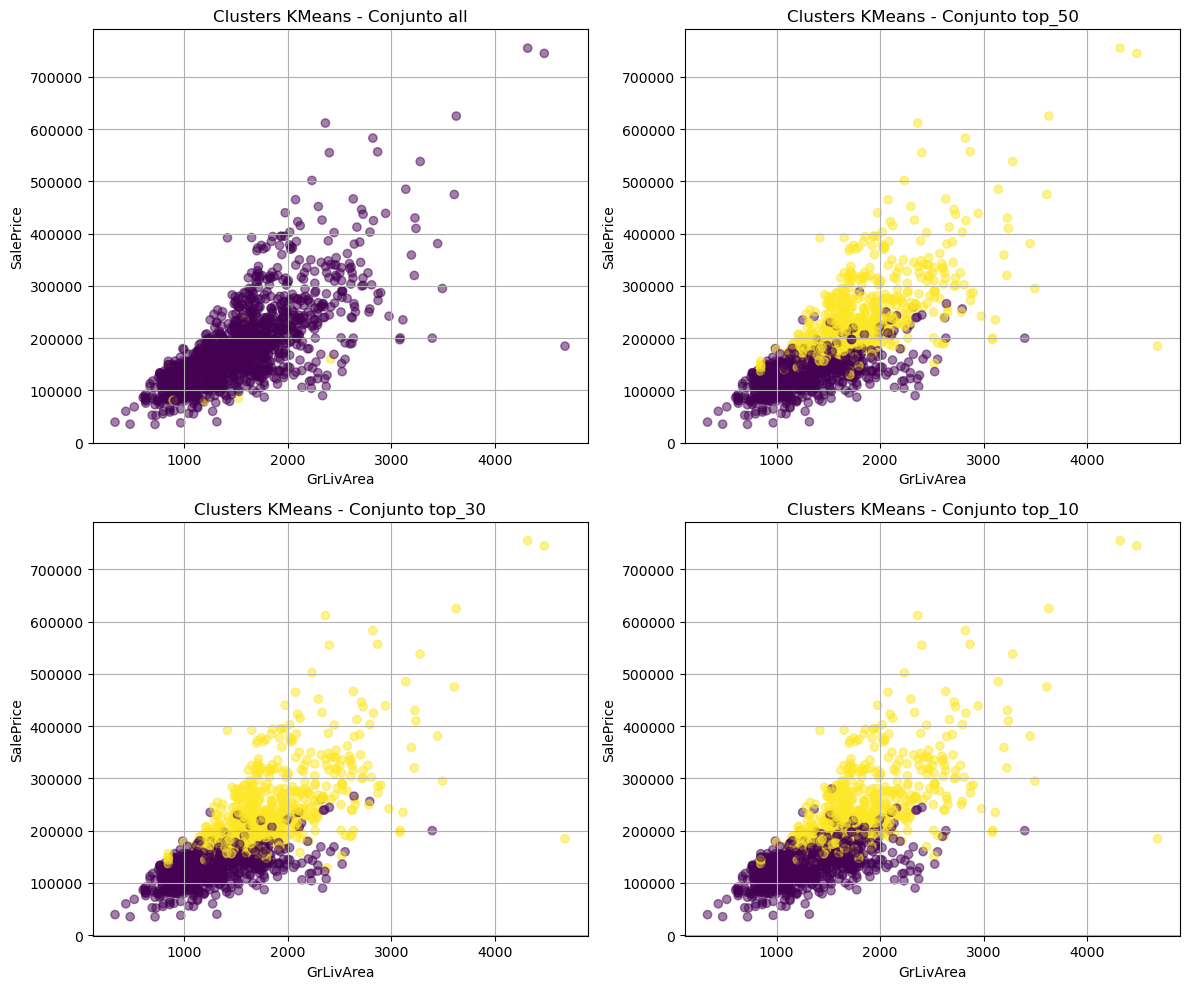

In [5]:
# Cargar los datos y las importancias de características
cleaned_data = pd.read_csv("Data/train_2.csv")
importances = pd.read_csv('Data/feature_importances.csv')

# Crear listas de características para cada tamaño de subconjunto incluyendo SalePrice y GrLivArea
top_features_with_addition = {
    'all': cleaned_data.columns.drop('SalePrice').tolist() + ['SalePrice'],  # Asegúrate de incluir 'GrLivArea' si es necesario
    'top_50': importances['Feature'].head(50).values.tolist() + ['SalePrice'],
    'top_30': importances['Feature'].head(30).values.tolist() + ['SalePrice'],
    'top_10': importances['Feature'].head(10).values.tolist() + ['SalePrice']
}

# Configurar la cuadrícula de gráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Iterar sobre cada subconjunto de características
for idx, (label, features) in enumerate(top_features_with_addition.items()):
    # Seleccionar el subconjunto de características
    X_subset = cleaned_data[features]

    # Normalizar los datos (excluyendo SalePrice de la normalización)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(X_subset.drop(columns=['SalePrice']))

    # Ejecutar KMeans con K=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data_scaled)
    X_subset['Cluster'] = kmeans.labels_  # Agregar las etiquetas de clúster

    # **Asegurarte de que 'SalePrice' esté disponible**
    X_subset['SalePrice'] = cleaned_data['SalePrice']  # Volver a agregar SalePrice al DataFrame

    # Graficar
    axes[idx].scatter(X_subset['GrLivArea'], X_subset['SalePrice'], c=X_subset['Cluster'], cmap='viridis', alpha=0.5)
    axes[idx].set_title(f'Clusters KMeans - Conjunto {label}')
    axes[idx].set_xlabel('GrLivArea')
    axes[idx].set_ylabel('SalePrice')
    axes[idx].grid()

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()



Se vuelven a usar los 4 conjuntos para obtener los **clusters**. Como era de esperar, al usar todas las variables, la **clusterización** no es clara, pero con las 50 mejores ya se observan dos **clusters** diferenciados.


C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


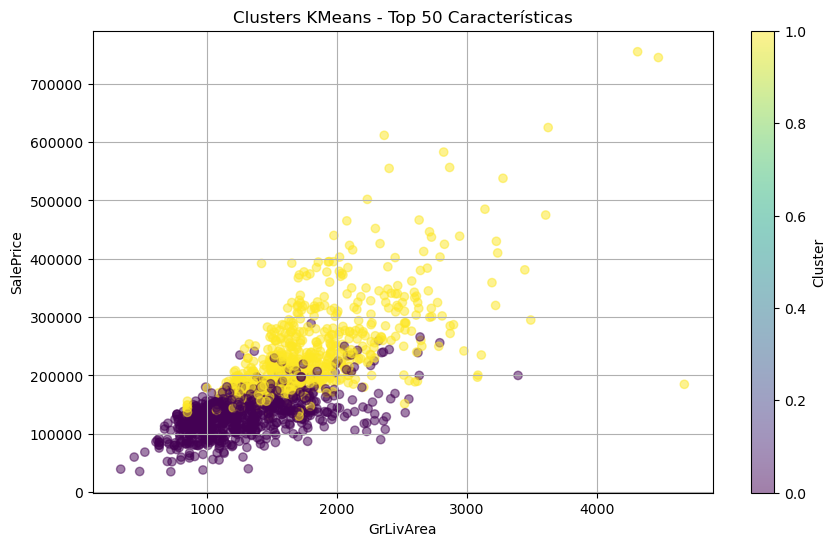

In [6]:
# Cargar los datos y las importancias de características
cleaned_data = pd.read_csv("Data/train_2.csv")
importances = pd.read_csv('Data/feature_importances.csv')

# Crear lista de características para el top 50 incluyendo 'GrLivArea' y 'SalePrice'
top_features_50 = importances['Feature'].head(50).values.tolist() + ['SalePrice']

# Seleccionar el subconjunto de características
X_subset = cleaned_data[top_features_50].copy()

# Normalizar los datos (excluyendo 'SalePrice' para el clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_subset.drop(columns=['SalePrice']))

# Ejecutar KMeans con K=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

# Obtener las etiquetas y el centroide de los clusters
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_subset['GrLivArea'], X_subset['SalePrice'], c=labels, cmap='viridis', alpha=0.5)
plt.title('Clusters KMeans - Top 50 Características')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.colorbar(label='Cluster')  # Añadir barra de color para mostrar clústeres
plt.grid()
plt.show()


# Crear una copia del DataFrame original para evitar modificarlo en su lugar
cleaned_data_copy = cleaned_data.copy()

# Añadir la columna 'Cluster' al DataFrame copiado
cleaned_data_copy['Cluster'] = kmeans.labels_

# Guardar el DataFrame copiado con la nueva columna 'Cluster' en un archivo CSV
cleaned_data_copy.to_csv('Data/cleaned_data_with_clusters.csv', index=False)

Nos quedamos con **K=2** en las **50 mejores características**, pues con esta combinación obtenemos dos clusters plenamente diferenciados y no perdemos demasiadas variables.


### Análisis de los datos de cada cluster

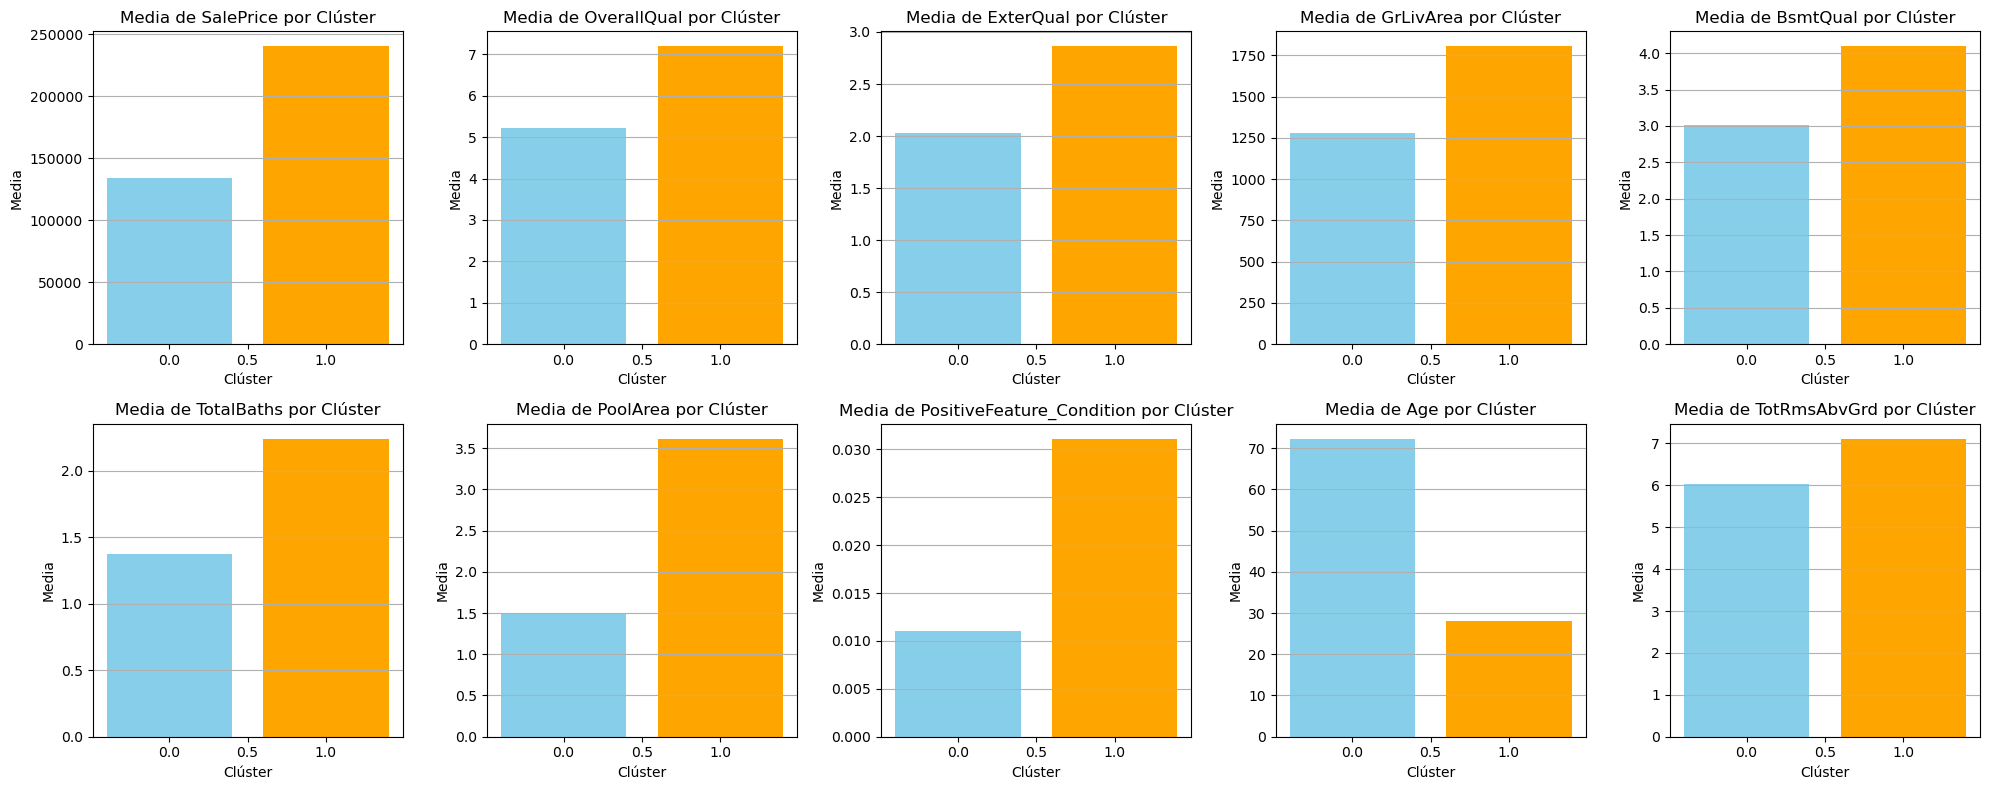

In [8]:
# Cargar los datos que ya incluyen la columna Cluster
cleaned_data = pd.read_csv("Data/cleaned_data_with_clusters.csv")

# Variables a comparar
variables_to_compare = [
    'SalePrice',
    'OverallQual',
    'ExterQual',
    'GrLivArea',
    'BsmtQual', 
    'TotalBaths',     
    'PoolArea',  
    'PositiveFeature_Condition',
    'Age',  
    'TotRmsAbvGrd'  
]

# Calcular la media por clúster
mean_comparison = cleaned_data.groupby('Cluster')[variables_to_compare].mean().reset_index()

# Crear subplots en un arreglo de 2 filas y 5 columnas
num_vars = len(variables_to_compare)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Ajustar el tamaño para mejor visualización
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Graficar las medias en subplots individuales
for i, variable in enumerate(variables_to_compare):
    axes[i].bar(mean_comparison['Cluster'], mean_comparison[variable], color=['skyblue', 'orange'])
    axes[i].set_title(f'Media de {variable} por Clúster')
    axes[i].set_ylabel('Media')
    axes[i].set_xlabel('Clúster')
    axes[i].grid(axis='y')

# Ajustar el diseño
plt.tight_layout()
plt.show()


Como se observa en estas gráficas, los clusters se agrupan claramente en **función del valor de las viviendas**. Esto se refleja tanto en la variable **SalePrice** (que no fue utilizada para la agrupación) como en otras variables relacionadas con calidad y superficie, que presentan valores más altos en el **clúster 1**. Por otro lado, la variable **Age**, que indica la antigüedad de la vivienda, es, como era de esperar, mayor en el **clúster 0**.



C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\2871379406.py:13: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  cleaned_data['Neighborhood'].cat.rename_categories(neighborhood_labels, inplace=True)


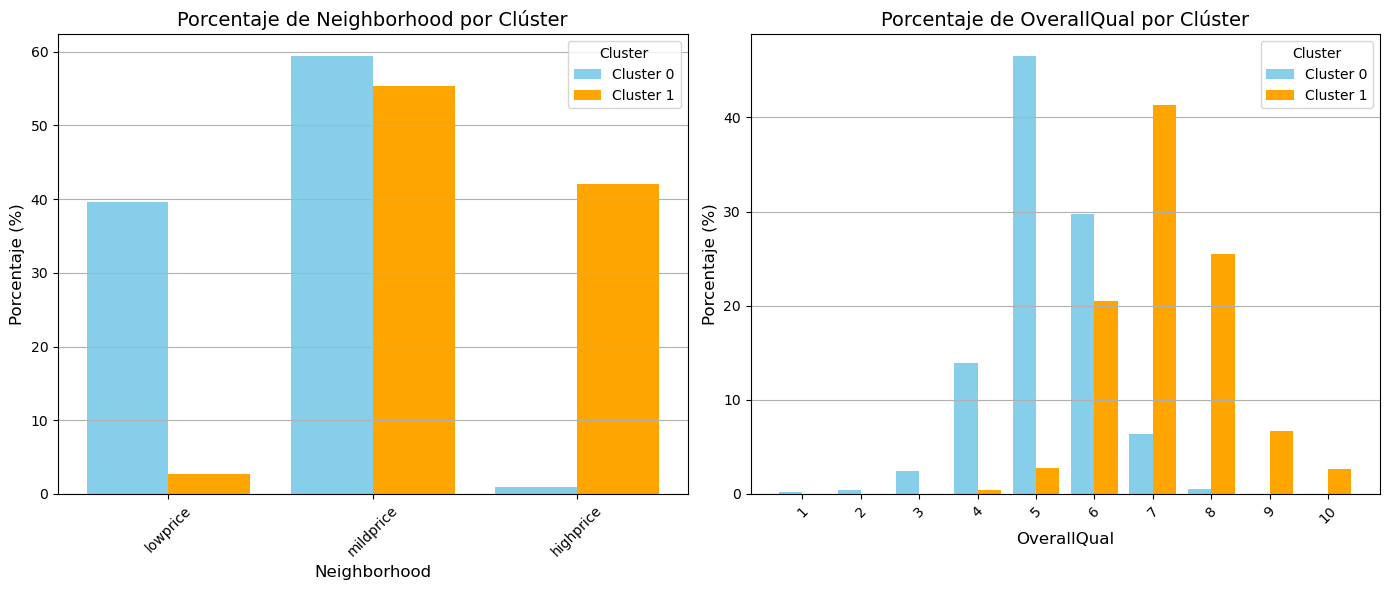

In [26]:
# Cargar los datos que ya incluyen la columna Cluster
cleaned_data = pd.read_csv("Data/cleaned_data_with_clusters.csv")

# Variables a tratar como categóricas
categorical_variables = ['Neighborhood', 'OverallQual']

# Convertir las variables a tipo categórico y cambiar nombres en Neighborhood
cleaned_data['Neighborhood'] = cleaned_data['Neighborhood'].astype('category')
cleaned_data['OverallQual'] = cleaned_data['OverallQual'].astype('category')

# Asignar nombres personalizados a las categorías de Neighborhood
neighborhood_labels = {0: 'lowprice', 1: 'mildprice', 2: 'highprice'}
cleaned_data['Neighborhood'].cat.rename_categories(neighborhood_labels, inplace=True)

# Crear una figura y ejes para las subgráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila y 2 columnas
axes = axes.flatten()  # Aplanar la matriz de ejes

# Graficar el porcentaje por clúster para cada variable categórica
for i, variable in enumerate(categorical_variables):
    # Contar las ocurrencias por categoría y clúster y convertirlas a porcentaje
    counts = cleaned_data.groupby(['Cluster', variable]).size().unstack(fill_value=0)
    counts_percentage = counts.div(counts.sum(axis=1), axis=0) * 100

    # Configurar las posiciones para barras agrupadas
    x = counts_percentage.columns  # categorías en el eje x
    x_indices = range(len(x))  # posiciones de las categorías en el gráfico
    bar_width = 0.4  # ancho de cada barra

    # Graficar barras para cada clúster en cada categoría
    axes[i].bar([index - bar_width / 2 for index in x_indices], counts_percentage.loc[0], 
                width=bar_width, label='Cluster 0', color='skyblue')
    axes[i].bar([index + bar_width / 2 for index in x_indices], counts_percentage.loc[1], 
                width=bar_width, label='Cluster 1', color='orange')

    # Configuración de las gráficas
    axes[i].set_title(f'Porcentaje de {variable} por Clúster', fontsize=14)  # Cambiado de "Conteo" a "Porcentaje"
    axes[i].set_ylabel('Porcentaje (%)', fontsize=12)
    axes[i].set_xlabel(variable, fontsize=12)
    axes[i].set_xticks(x_indices)  # Posiciones de las categorías en el eje x
    axes[i].set_xticklabels(x, rotation=45)  # Nombres de las categorías
    axes[i].legend(title='Cluster')
    axes[i].grid(axis='y')

# Ajustar el diseño
plt.tight_layout()
plt.show()


Aquí comparamos dos variables que en realidad son **categóricas** y comparamos la distribución de cada cluster en las disitintas categorías. Siendo los resultados coherentes con la **asociación del cluster 1 a viviendas más caras**.

## Clusterización del conjunto de prueba.

In [10]:
# Cargar el conjunto de datos de prueba
test = pd.read_csv("Data/test_2.csv")

# Seleccionar el mismo subconjunto de características utilizado para entrenar el modelo, excluyendo 'SalePrice'
top_features_50_no_saleprice = [feature for feature in top_features_50 if feature != 'SalePrice']
test_subset = test[top_features_50_no_saleprice].copy()

# Normalizar el conjunto de prueba usando el mismo escalador ajustado en el conjunto de entrenamiento
test_scaled = scaler.transform(test_subset)

# Predecir el clúster de cada fila del conjunto de prueba utilizando el modelo KMeans entrenado
test['Cluster'] = kmeans.predict(test_scaled)

# Guardar el conjunto de prueba con las etiquetas de clúster
test.to_csv("Data/test_with_clusters.csv", index=False)



### Análisis de los datos de cada cluster

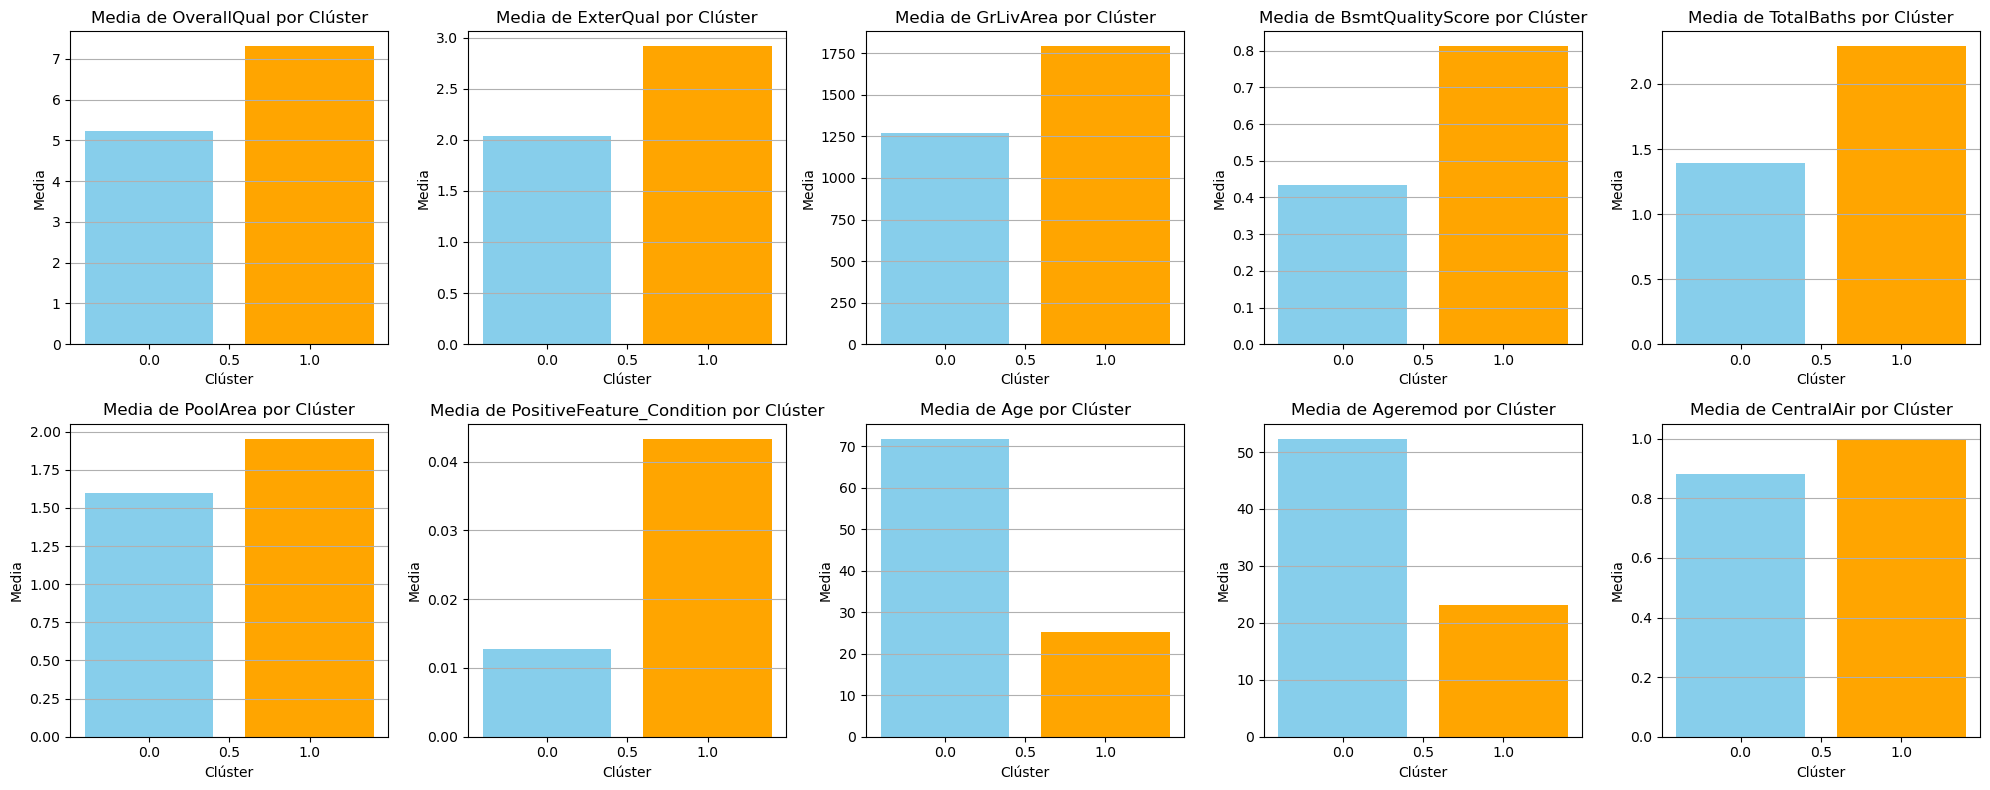

In [11]:
# Cargar los datos de prueba que ya incluyen la columna Cluster
test_data = pd.read_csv("Data/test_with_clusters.csv")

# Variables a comparar, excluyendo 'SalePrice' porque no está en el conjunto de prueba
variables_to_compare = [
    'OverallQual',
    'ExterQual',
    'GrLivArea',
    'BsmtQualityScore', 
    'TotalBaths',     
    'PoolArea',  
    'PositiveFeature_Condition',
    'Age',  
    'Ageremod', 
    'CentralAir'  
]

# Calcular la media por clúster
mean_comparison = test_data.groupby('Cluster')[variables_to_compare].mean().reset_index()

# Crear subplots en un arreglo de 2 filas y 5 columnas
num_vars = len(variables_to_compare)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Ajustar el tamaño para mejor visualización
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Graficar las medias en subplots individuales
for i, variable in enumerate(variables_to_compare):
    axes[i].bar(mean_comparison['Cluster'], mean_comparison[variable], color=['skyblue', 'orange'])
    axes[i].set_title(f'Media de {variable} por Clúster')
    axes[i].set_ylabel('Media')
    axes[i].set_xlabel('Clúster')
    axes[i].grid(axis='y')

# Ajustar el diseño
plt.tight_layout()
plt.show()


Comprobamos que los clusters tienen el **mismo comportamiento** respecto a las variables clave en el conjunto de prueba.

# Predicciones en test

Ahora vamos a entrenar dos modelos (**Gradient Boosting** y una **red neuronal**) con los hiperparámetros optimizados para cada uno de los **clusters**. Esto nos permitirá crear dos modelos diferentes que se utilizarán para realizar las predicciones en el conjunto de entrenamiento.


## Gradient Boosting

### Entrenamiento

In [12]:
# Cargar los datos con la columna Cluster ya incluida
cleaned_data = pd.read_csv("Data/cleaned_data_with_clusters.csv")

# Dividir el cleaned_data en dos subconjuntos según el valor del clúster
cleaned_data_0 = cleaned_data[cleaned_data['Cluster'] == 0]
cleaned_data_1 = cleaned_data[cleaned_data['Cluster'] == 1]

# Entrenar el modelo de Gradient Boosting para cada clúster
for cluster, data in [('0', cleaned_data_0), ('1', cleaned_data_1)]:
    # Separar características y variable objetivo
    X = data.drop(columns=['SalePrice', 'Cluster'])
    y = data['SalePrice']
    
    # Normalizar los datos
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Definir el modelo de Gradient Boosting con los mejores hiperparámetros
    gb_model = GradientBoostingRegressor(
        n_estimators=2500,         
        learning_rate=0.01,        
        max_depth=4,               
        max_features='sqrt',       
        subsample=1.0,             
        random_state=42            
    )
    
    # Entrenar el modelo
    print(f"Entrenando el modelo para Cluster {cluster}...")
    gb_model.fit(X_scaled, y)
    
    # Guardar el modelo entrenado
    joblib.dump(gb_model, f"Data/gb_model_cluster_{cluster}.pkl")
    joblib.dump(scaler, f"Data/scaler_cluster_{cluster}.pkl")  # Guardar el escalador también
    print(f"Modelo para Cluster {cluster} guardado en 'Data/gb_model_cluster_{cluster}.pkl'.")

print("Entrenamiento y guardado de modelos completado.")

Entrenando el modelo para Cluster 0...
Modelo para Cluster 0 guardado en 'Data/gb_model_cluster_0.pkl'.
Entrenando el modelo para Cluster 1...
Modelo para Cluster 1 guardado en 'Data/gb_model_cluster_1.pkl'.
Entrenamiento y guardado de modelos completado.


### Importancia de las características

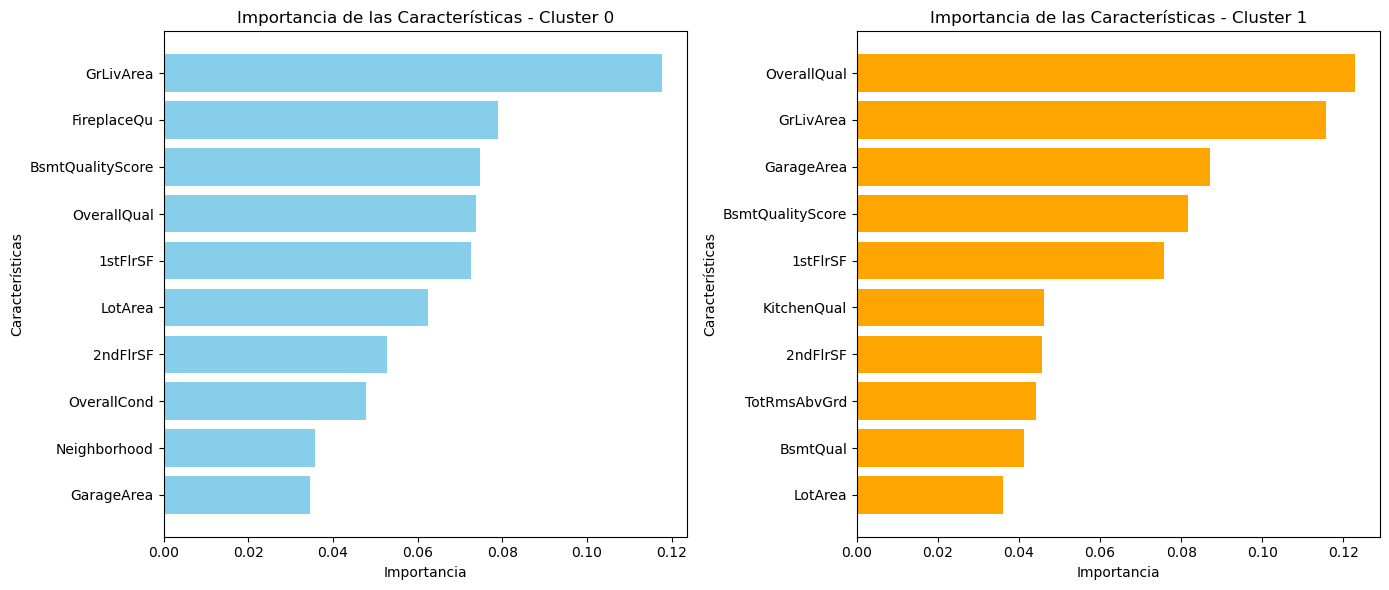

In [13]:
# Cargar los modelos de Gradient Boosting y los escaladores para cada clúster
gb_model_0 = joblib.load("Data/gb_model_cluster_0.pkl")
gb_model_1 = joblib.load("Data/gb_model_cluster_1.pkl")

# Extraer las importancias de las características de cada modelo
importances_0 = gb_model_0.feature_importances_
importances_1 = gb_model_1.feature_importances_

# Obtener los nombres de las características del conjunto de datos (usado previamente)
cleaned_data = pd.read_csv("Data/cleaned_data_with_clusters.csv")
X = cleaned_data.drop(columns=['SalePrice', 'Cluster'])
feature_names = X.columns

# Crear un DataFrame con las importancias y características
importance_df_0 = pd.DataFrame({'Feature': feature_names, 'Importance': importances_0})
importance_df_1 = pd.DataFrame({'Feature': feature_names, 'Importance': importances_1})

# Ordenar las importancias de mayor a menor
importance_df_0 = importance_df_0.sort_values(by='Importance', ascending=False).head(10)
importance_df_1 = importance_df_1.sort_values(by='Importance', ascending=False).head(10)

# Crear las subgráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas
axes = axes.flatten()  # Aplanar los ejes para que sea más fácil trabajar con ellos

# Graficar las 10 características más importantes para el Cluster 0
axes[0].barh(importance_df_0['Feature'], importance_df_0['Importance'], color='skyblue')
axes[0].set_title('Importancia de las Características - Cluster 0')
axes[0].set_xlabel('Importancia')
axes[0].set_ylabel('Características')
axes[0].invert_yaxis()  # Invertir el eje Y para que las características más importantes estén arriba

# Graficar las 10 características más importantes para el Cluster 1
axes[1].barh(importance_df_1['Feature'], importance_df_1['Importance'], color='orange')
axes[1].set_title('Importancia de las Características - Cluster 1')
axes[1].set_xlabel('Importancia')
axes[1].set_ylabel('Características')
axes[1].invert_yaxis()  # Invertir el eje Y para que las características más importantes estén arriba

# Ajustar el diseño y mostrar las gráficas
plt.tight_layout()
plt.show()


### Predicciones

In [14]:
# Cargar los datos de prueba con los clústeres asignados
test_data = pd.read_csv("Data/test_with_clusters.csv")

# Cargar los modelos y escaladores guardados
gb_model_cluster_0 = joblib.load("Data/gb_model_cluster_0.pkl")
gb_model_cluster_1 = joblib.load("Data/gb_model_cluster_1.pkl")

# Separar los datos de prueba por clúster
test_data_0 = test_data[test_data['Cluster'] == 0]
test_data_1 = test_data[test_data['Cluster'] == 1]

# Normalizar y predecir para cada clúster
# Asegúrate de que todas las columnas de características estén en el mismo orden que en el entrenamiento

# Escalador para Cluster 0
scaler_0 = joblib.load("Data/scaler_cluster_0.pkl")  # Cargar el escalador guardado para el clúster 0
X_test_cluster_0_scaled = scaler_0.transform(test_data_0.drop(columns=['Id', 'Cluster']))
predictions_0 = gb_model_cluster_0.predict(X_test_cluster_0_scaled)

# Escalador para Cluster 1
scaler_1 = joblib.load("Data/scaler_cluster_1.pkl")  # Cargar el escalador guardado para el clúster 1
X_test_cluster_1_scaled = scaler_1.transform(test_data_1.drop(columns=['Id', 'Cluster']))
predictions_1 = gb_model_cluster_1.predict(X_test_cluster_1_scaled)

# Agregar las predicciones al DataFrame de prueba
test_data_0['SalePrice'] = predictions_0
test_data_1['SalePrice'] = predictions_1

# Concatenar los resultados y ordenar por el índice original para asegurar el orden
submission = pd.concat([test_data_0[['Id', 'SalePrice']], test_data_1[['Id', 'SalePrice']]])
submission = submission.sort_index()  # Restaurar el orden original

# Guardar el archivo de salida en el formato adecuado para Kaggle
submission.to_csv('Data/submission_gradient_boosting_clusters.csv', index=False)

print("Predicciones guardadas en 'Data/submission_gradient_boosting_clusters.csv'")

Predicciones guardadas en 'Data/submission_gradient_boosting_clusters.csv'


C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\3458513381.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_0['SalePrice'] = predictions_0
C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\3458513381.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_1['SalePrice'] = predictions_1


![Resultados para gradient_clusters](Images/gradient_clusters.png)


## Red Neuronal

### Entrenamiento

In [15]:
# Cargar los datos con la columna Cluster ya incluida
cleaned_data = pd.read_csv("Data/cleaned_data_with_clusters.csv")

# Dividir el cleaned_data en dos subconjuntos según el valor del clúster
cleaned_data_0 = cleaned_data[cleaned_data['Cluster'] == 0]
cleaned_data_1 = cleaned_data[cleaned_data['Cluster'] == 1]

# Entrenar la red neuronal para cada clúster
for cluster, data in [('0', cleaned_data_0), ('1', cleaned_data_1)]:
    # Separar características y variable objetivo
    X = data.drop(columns=['SalePrice', 'Cluster'])
    y = data['SalePrice']
    
    # Normalizar los datos
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42
)
    
    # Entrenar el modelo
    print(f"Entrenando el modelo para Cluster {cluster}...")
    mlp_model.fit(X_scaled, y)
    
    # Guardar el modelo entrenado
    joblib.dump(mlp_model, f"Data/mlp_model_cluster_{cluster}.pkl")
    print(f"Modelo para Cluster {cluster} guardado en 'Data/mlp_model_cluster_{cluster}.pkl'.")

print("Entrenamiento y guardado de modelos completado.")

Entrenando el modelo para Cluster 0...
Modelo para Cluster 0 guardado en 'Data/mlp_model_cluster_0.pkl'.
Entrenando el modelo para Cluster 1...
Modelo para Cluster 1 guardado en 'Data/mlp_model_cluster_1.pkl'.
Entrenamiento y guardado de modelos completado.


C:\Users\oscar\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Predicciones

In [16]:
# Cargar los datos de prueba con los clústeres asignados
test_data = pd.read_csv("Data/test_with_clusters.csv")

# Cargar los modelos y escaladores guardados
mlp_model_cluster_0 = joblib.load("Data/mlp_model_cluster_0.pkl")
mlp_model_cluster_1 = joblib.load("Data/mlp_model_cluster_1.pkl")

# Separar los datos de prueba por clúster
test_data_0 = test_data[test_data['Cluster'] == 0]
test_data_1 = test_data[test_data['Cluster'] == 1]

# Escalador para Cluster 0
scaler_0 = MinMaxScaler()
X_train_cluster_0 = cleaned_data[cleaned_data['Cluster'] == 0].drop(columns=['SalePrice', 'Cluster'])
scaler_0.fit(X_train_cluster_0)  # Ajustar el escalador solo al subconjunto de entrenamiento del clúster 0
X_test_cluster_0_scaled = scaler_0.transform(test_data_0.drop(columns=['Id', 'Cluster']))
predictions_0 = mlp_model_cluster_0.predict(X_test_cluster_0_scaled)

# Escalador para Cluster 1
scaler_1 = MinMaxScaler()
X_train_cluster_1 = cleaned_data[cleaned_data['Cluster'] == 1].drop(columns=['SalePrice', 'Cluster'])
scaler_1.fit(X_train_cluster_1)  # Ajustar el escalador solo al subconjunto de entrenamiento del clúster 1
X_test_cluster_1_scaled = scaler_1.transform(test_data_1.drop(columns=['Id', 'Cluster']))
predictions_1 = mlp_model_cluster_1.predict(X_test_cluster_1_scaled)

# Agregar las predicciones al DataFrame de prueba
test_data_0['SalePrice'] = predictions_0
test_data_1['SalePrice'] = predictions_1

# Concatenar los resultados y ordenar por el índice original para asegurar el orden
submission = pd.concat([test_data_0[['Id', 'SalePrice']], test_data_1[['Id', 'SalePrice']]])
submission = submission.sort_index()  # Restaurar el orden original

# Guardar el archivo de salida en el formato adecuado para Kaggle
submission.to_csv('Data/submission_neural_network_clusters.csv', index=False)

print("Predicciones guardadas en 'Data/submission_neural_network_clusters.csv'")


Predicciones guardadas en 'Data/submission_neural_network_clusters.csv'


C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\427499703.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_0['SalePrice'] = predictions_0
C:\Users\oscar\AppData\Local\Temp\ipykernel_43044\427499703.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_1['SalePrice'] = predictions_1


![Resultados para red](Images/red_clusters_2.png)

Los datos de **Gradient Boosting** mejoran a los del modelo entrenado con el conjunto completo, lo que sugiere que cada grupo tiene patrones distintos, es decir, la relación entre las características y el precio es diferente entre esos subgrupos. Esta teoría se confirma al observar las gráficas de importancia de características de cada modelo. En conclusión, se consigue en un solo modelo capturar todas las interacciones posibles.

En el caso de la **red neuronal** los resultados no mejoran, seguramente se debe principalmente al **tamaño limitado del conjunto de datos** original. Al partir de un dataset de menos de 1500 muestras y dividirlo en dos clusters, el número de muestras disponible para cada submodelo de **red neuronal** no fue suficiente para un entrenamiento efectivo. Las **redes neuronales** requieren un volumen mayor de datos para aprender patrones complejos de manera generalizable, mientras que los modelos como el **GBT** suelen ser más robustos en situaciones de datos pequeños o medianos. La menor tendencia a sobreajustarse de la **red** frente a **GBT** y la mayor capacidad de generalización de las **redes neuronales** en general, podrían hacer que con un número de muestras de entrenamiento funcione mejor en un caso real.

